In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tbparse import SummaryReader
import pickle
from scipy.stats import iqr
from meher.utils import parse_tb_data, tb_to_stats
from itertools import permutations
import os

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']*2

2023-10-09 07:25:09.698095: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-09 07:25:09.707432: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 07:25:09.761945: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 07:25:09.762689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 07:25:10.721213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def find_95_max(mean):
    max = np.max(mean)
    max_loc = np.argmax(mean)
    max_95 = .95*max
    diffs = np.abs(np.array(mean)[:max_loc-1] - max_95)
    time_to_learn = np.argmin(diffs)
    return time_to_learn

In [8]:
# files_path = '/home/mltrapp/meher/tune/predator_corr_adam_weight_decay'
# files_path = '/home/mltrapp/meher/tune/coll_and_preds_custom_actor/num_preds=3,preds_collide=True'
files_path = '/home/mltrapp/meher/tune/ppo_custom_actor_3_preds_coll'
reader = SummaryReader(files_path, pivot=True, extra_columns={'dir_name'})
df = reader.scalars
exp_names = list(set(df['dir_name']))
m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))



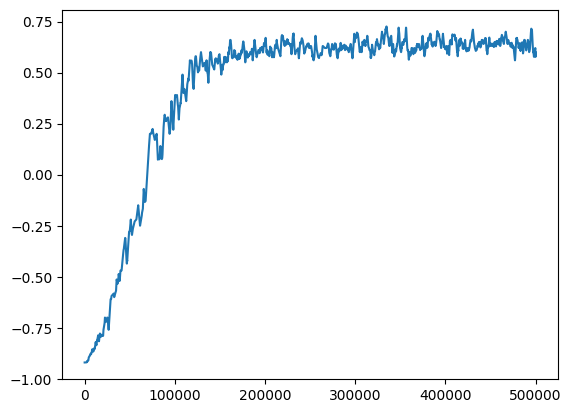

In [7]:
# np.mean(df['rollout/ep_rew_mean'])
# df.head()
plt.plot(m)


In [5]:
# # files_path = '/home/mltrapp/meher/tune/coll_and_preds_3/'
# files_path = '/home/mltrapp/meher/tune/test_predator_noise_adam_weight_decay/num_preds=1'
# reader = SummaryReader(files_path, pivot=True, extra_columns={'dir_name'})
# df = reader.scalars
# # exp_names = list(set(df['dir_name']))
# # m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
# # exp_names
# df.head()

## Master from 10/5/23 vs Possible uncomp commit


In [4]:

files_path = '/home/mltrapp/meher/tune/actor_3_preds_master_branch'
master_m, std, master_t, master_b, all_repeat_rew = tb_to_stats(files_path, int(500E3))


files_path = '/home/mltrapp/meher/tune/maybe_uncomp_3_preds_collide_true_actor'
uncomp_m, std, uncomp_t, uncomp_b, all_repeat_rew = tb_to_stats(files_path, int(500E3))

files_path = '/home/mltrapp/meher/tune/coll_and_preds_custom_actor/num_preds=3,preds_collide=True'
aiaa_m, _, aiaa_t, aiaa_b, all_repeat_rew = tb_to_stats(files_path, int(500E3))

files_path = '/home/mltrapp/meher/tune/ppo_custom_actor_3_preds_coll'
c_ppo_net_m, _, c_ppo_net_t, c_ppo_net_b, all_repeat_rew = tb_to_stats(files_path, int(500E3))


files_path = '/home/mltrapp/meher/tune/actor_3_preds_master_branch_edit_init_order'
init_edit_m, _, init_edit_t, init_edit_b, all_repeat_rew = tb_to_stats(files_path, int(500E3))

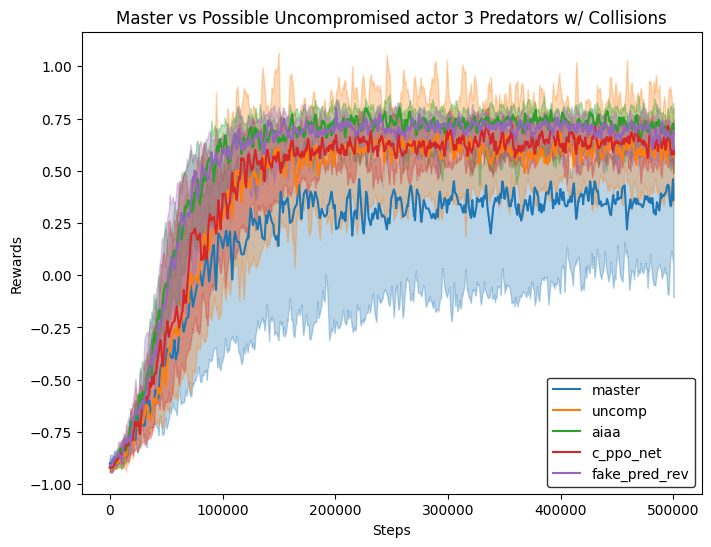

In [5]:

plt.figure(figsize=(8,6))

plt.plot(master_m, label='master', color=colors[0])
plt.fill_between(np.arange(len(master_m)), master_m+master_t, master_m-master_b, alpha=0.3, color=colors[0])
                 
plt.plot(uncomp_m, label='uncomp', color=colors[1])
plt.fill_between(np.arange(len(uncomp_m)), uncomp_m+master_t, uncomp_m-uncomp_b, alpha=0.3, color=colors[1])
                 
plt.plot(aiaa_m, label='aiaa', color=colors[2])
plt.fill_between(np.arange(len(aiaa_m)), aiaa_m+aiaa_t, aiaa_m-aiaa_b, alpha=0.3, color=colors[2])

plt.plot(c_ppo_net_m, label='c_ppo_net', color=colors[3])
plt.fill_between(np.arange(len(c_ppo_net_m)), c_ppo_net_m+c_ppo_net_t, c_ppo_net_m-c_ppo_net_b, alpha=0.3, color=colors[3])

plt.plot(init_edit_m, label='fake_pred_revert', color=colors[4])
plt.fill_between(np.arange(len(init_edit_m)), init_edit_m+init_edit_t, init_edit_m-init_edit_b, alpha=0.3, color=colors[4])


plt.title('Master vs Possible Uncompromised actor 3 Predators w/ Collisions')
plt.xlabel('Steps')
plt.ylabel('Rewards')
leg = plt.legend(loc=('lower right'))
leg.get_frame().set_linewidth(1)
leg.get_frame().set_edgecolor('black')

# plt.savefig('coll_and_preds_custom_actor.pdf', format='pdf')
# plt.savefig('coll_and_preds_custom_actor.png', format='png')

plt.show()

In [4]:
adam_means = []
adam_tops = []
adam_bottoms =[]
preds = ['L2=0_eps=1e-5', 'L2=0_eps=1e-8', 'L2=0.0005_eps=1e-5', 'L2=0.0005_eps=1e-8']
for num_preds in preds:
    files_path = '/home/mltrapp/meher/tune/best_l2_wEPS_vs_vanilla_n_preds/' + str(num_preds)
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    adam_means.append(m)
    adam_tops.append(t)
    adam_bottoms.append(b)

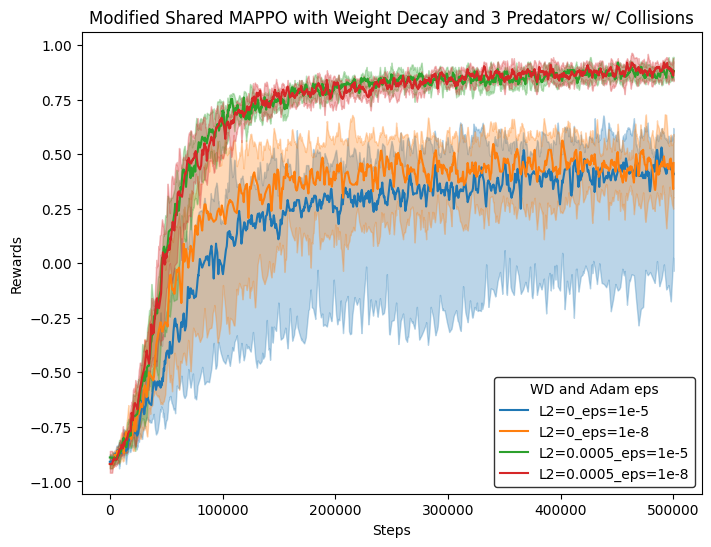

In [7]:
labels = preds
plt.figure(figsize=(8,6))
for m, t, b, n ,c in zip(adam_means, adam_tops, adam_bottoms, labels, colors):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
plt.title('Modified Shared MAPPO with Weight Decay and 3 Predators w/ Collisions')
plt.xlabel('Steps')
plt.ylabel('Rewards')
leg = plt.legend(title='WD and Adam eps', loc=('lower right'))
leg.get_frame().set_linewidth(1)
leg.get_frame().set_edgecolor('black')

# plt.savefig('coll_and_preds_custom_actor.pdf', format='pdf')
# plt.savefig('coll_and_preds_custom_actor.png', format='png')

plt.show()

# Pred and Collisions


In [6]:
means = []
tops = []
bottoms =[]
labels = [(str(n), b) for n in range(1,4) for b in ['True']]
# labels.remove(('1', 'True'))
for n_preds, b in labels:
    files_path = '/home/mltrapp/meher/tune/coll_and_preds_3/preds='+ str(n_preds)+',coll=True' 
    # f'/home/mltrapp/meher/tune/full_correlation_custom_actor/preds={n_preds}_collide={b}' 
    # print(files_path)
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    means.append(m)
    tops.append(t)
    bottoms.append(b)
    
adam_means = []
adam_tops = []
adam_bottoms =[]
preds = ['adam_num_preds=1', 'adam_num_preds=2', 'adam_num_preds=3']
for num_preds in preds:
    files_path = '/home/mltrapp/meher/tune/WD_0.001_adam_real_preds_coll/num_preds=' + str(num_preds[-1])
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    adam_means.append(m)
    adam_tops.append(t)
    adam_bottoms.append(b)
    
adamW_means = []
adamW_tops = []
adamW_bottoms =[]
Wpreds = ['adamW_num_preds=1', 'adamW_num_preds=2', 'adamW_num_preds=3']
for num_preds in preds:
    files_path = '/home/mltrapp/meher/tune/WD_0.001_adamW_real_preds_coll/num_preds=' + str(num_preds[-1])
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    adamW_means.append(m)
    adamW_tops.append(t)
    adamW_bottoms.append(b)

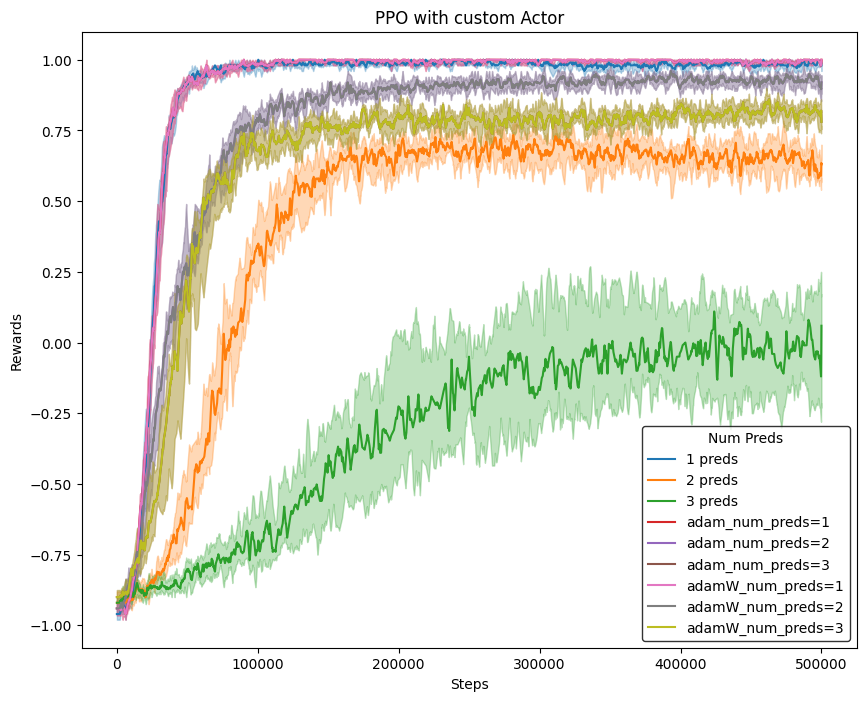

In [7]:
labels = [f'{n} preds' for n,b in labels]
plt.figure(figsize=(10,8))
for m, t, b, n ,c in zip(means, tops, bottoms, labels, colors):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
for m, t, b, n ,c in zip(adam_means, adam_tops, adam_bottoms, preds, colors[len(preds):]):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
for m, t, b, n ,c in zip(adam_means, adam_tops, adam_bottoms, Wpreds, colors[len(preds)*2:]):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
plt.title('PPO with custom Actor')
plt.xlabel('Steps')
plt.ylabel('Rewards')
leg = plt.legend(title='Num Preds', loc=('lower right'))
leg.get_frame().set_linewidth(1)
leg.get_frame().set_edgecolor('black')

# plt.savefig('coll_and_preds_custom_actor.pdf', format='pdf')
# plt.savefig('coll_and_preds_custom_actor.png', format='png')

plt.show()

# State Size
### Note
All means are actually medians computed in meher.utils.tb_to_stats

In [8]:
means = []
tops = []
bottoms =[]
n_preds = [0, 1, 2]
for num_preds in n_preds:
    files_path = '/home/mltrapp/meher/tune/state_size/num_fake_preds=' + str(num_preds)
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    means.append(m)
    tops.append(t)
    bottoms.append(b)

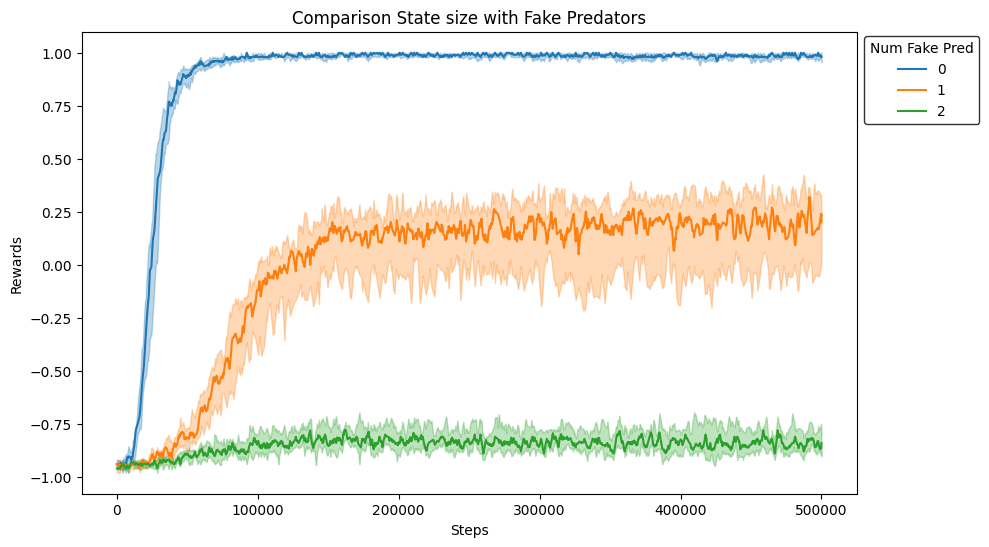

In [9]:
plt.figure(figsize=(10,6))
for m, t, b, n ,c in zip(means, tops, bottoms, n_preds, colors):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
plt.title('Comparison State size with Fake Predators')
plt.xlabel('Steps')
plt.ylabel('Rewards')
leg = plt.legend(title='Num Fake Pred', loc=(1.01, .8))
leg.get_frame().set_linewidth(1)
leg.get_frame().set_edgecolor('black')

plt.savefig('state_size_w_fake_pred_ppo.pdf', format='pdf')
plt.savefig('state_size_w_fake_pred_ppo.png', format='png')

plt.show()

## Time to max and Time to Learn

In [ ]:
def get_metrics_from_curve(labels, mean_array):
    pass

In [10]:
maxls = {'0': np.argmax(means[0]), '1': np.argmax(means[1]), '2':np.argmax(means[2])}
maxs = {'0': np.max(means[0]), '1': np.max(means[1]), '2':np.max(means[2])}
time_to_95 = {'0': find_95_max(means[0]), '1': find_95_max(means[1]), '2': find_95_max(means[2])}
state_size_df = pd.DataFrame({'Time to Max Reward': maxls, 'Time to Learn (95% max)': time_to_95, 'Max Reward':maxs})
state_size_df


,Time to Max Reward,Time to Learn (95% max),Max Reward
0,92160,66048,1.0000
1,491520,491302,0.3200
2,162304,162302,-0.7775


# State Correlation

In [11]:
means = []
tops = []
bottoms =[]
n_preds = ['none', 'predator', 'prey']
for num_preds in n_preds:
    files_path = '/home/mltrapp/meher/tune/state_correlation/fake_preds=' + str(num_preds)
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    means.append(m)
    tops.append(t)
    bottoms.append(b)
    
no_means = []
no_tops = []
no_bottoms =[]
n_preds = ['none', 'predator', 'prey']
for num_preds in n_preds:
    files_path = '/home/mltrapp/meher/tune/corr_noise_adam_no_weight_decay/fake_preds=' + str(num_preds)
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    no_means.append(m)
    no_tops.append(t)
    no_bottoms.append(b)

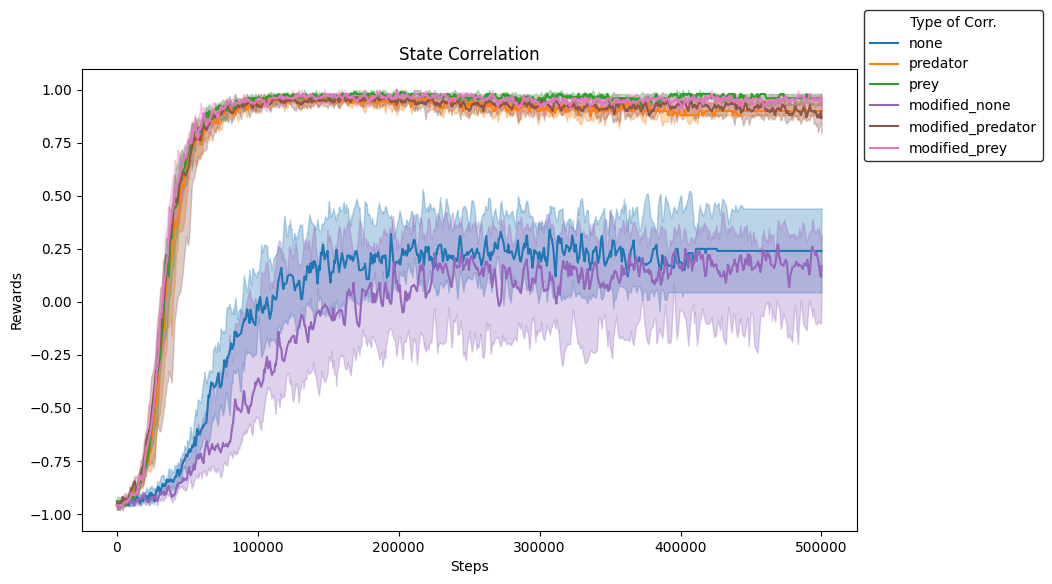

In [12]:
plt.figure(figsize=(10,6))
for m, t, b, n ,c in zip(means, tops, bottoms, n_preds, colors):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
for m, t, b, n ,c in zip(no_means, no_tops, no_bottoms, ['modified_none', 'modified_predator', 'modified_prey'], colors[len(num_preds):]):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
plt.title('State Correlation')
plt.xlabel('Steps')
plt.ylabel('Rewards')
leg = plt.legend(title='Type of Corr.', loc=(1.01, .8))
leg.get_frame().set_linewidth(1)
leg.get_frame().set_edgecolor('black')

plt.savefig('state_correlation.pdf', format='pdf')
plt.savefig('state_correlation.png', format='png')

plt.show()

In [13]:
maxls = {'none': np.argmax(means[0]), 'predator': np.argmax(means[1]), 'prey':np.argmax(means[2])}
maxs = {'none': np.max(means[0]), 'predator': np.max(means[1]), 'prey':np.max(means[2])}
time_to_95 = {'none': find_95_max(means[0]), 'predator': find_95_max(means[1]), 'prey': find_95_max(means[2])}
no_maxls = {'noL2_none': np.argmax(no_means[0]), 'noL2_predator': np.argmax(no_means[1]), 'noL2_prey':np.argmax(no_means[2])}
no_maxs = {'noL2_none': np.max(no_means[0]), 'noL2_predator': np.max(no_means[1]), 'noL2_prey':np.max(no_means[2])}
no_time_to_95 = {'noL2_none': find_95_max(no_means[0]), 'noL2_predator': find_95_max(no_means[1]), 'noL2_prey': find_95_max(no_means[2])}
state_size_df = pd.DataFrame({'Time to Max Reward': maxls, 'Time to Learn (95% max)': time_to_95, 'Max Reward': maxs})
state_size_df

,Time to Max Reward,Time to Learn (95% max),Max Reward
none,307328,306800,0.340625
predator,148480,87117,0.970000
prey,168960,104431,0.990000


# Reward Complexity
With predator corr.

In [14]:
means = []
tops = []
bottoms =[]
n_preds = ['False', 'True']
for num_preds in n_preds:
    files_path = '/home/mltrapp/meher/tune/reward_complexity_pred_corr/collide_with_fake=' + str(num_preds)
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    means.append(m)
    tops.append(t)
    bottoms.append(b)

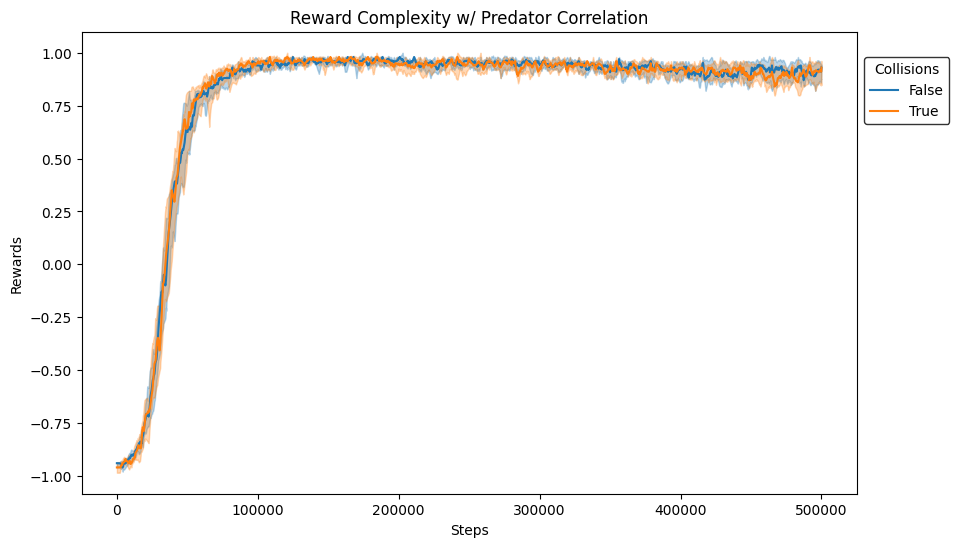

In [15]:
plt.figure(figsize=(10,6))
for m, t, b, n ,c in zip(means, tops, bottoms, n_preds, colors):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
plt.title('Reward Complexity w/ Predator Correlation')
plt.xlabel('Steps')
plt.ylabel('Rewards')
leg = plt.legend(title='Collisions', loc=(1.01, .8))
leg.get_frame().set_linewidth(1)
leg.get_frame().set_edgecolor('black')

plt.savefig('reward_complexity_pred_corr.pdf', format='pdf')
plt.savefig('reward_complexity_pred_corr.png', format='png')

plt.show()

In [16]:
maxls = {'False': np.argmax(means[0]), 'True': np.argmax(means[1])}
maxs = {'False': np.max(means[0]), 'True': np.max(means[1])}
time_to_95 = {'False': find_95_max(means[0]), 'True': find_95_max(means[1])}
state_size_df = pd.DataFrame({'Time to Max Reward': maxls, 'Time to Learn (95% max)': time_to_95, 'Max Reward': maxs})
state_size_df

,Time to Max Reward,Time to Learn (95% max),Max Reward
False,124928,95115,0.98000
True,184064,89712,0.98125


### with prey correlation

In [17]:
means = []
tops = []
bottoms =[]
n_preds = ['False', 'True']
for num_preds in n_preds:
    files_path = '/home/mltrapp/meher/tune/reward_complexity_prey_corr/collide_with_fake=' + str(num_preds)
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    means.append(m)
    tops.append(t)
    bottoms.append(b)

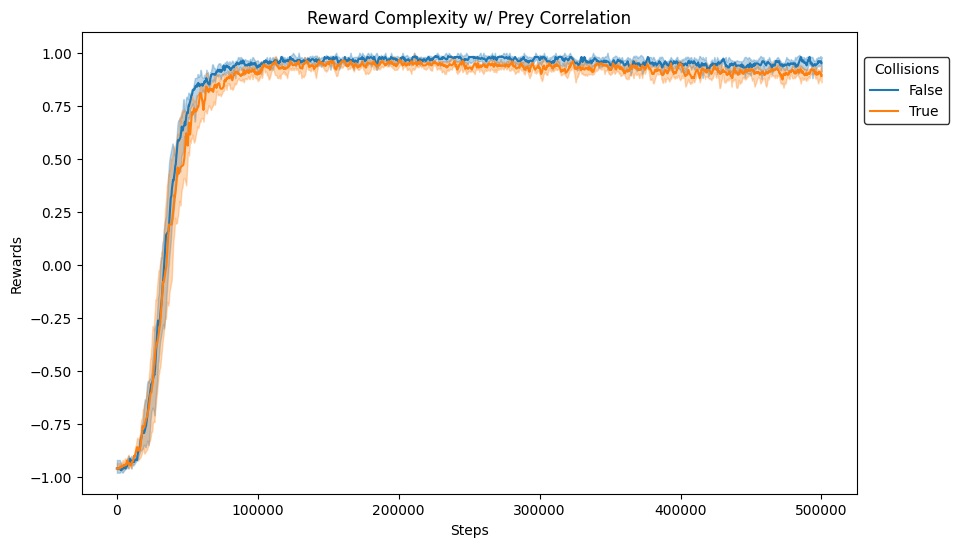

In [18]:
plt.figure(figsize=(10,6))
for m, t, b, n ,c in zip(means, tops, bottoms, n_preds, colors):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
plt.title('Reward Complexity w/ Prey Correlation')
plt.xlabel('Steps')
plt.ylabel('Rewards')
leg = plt.legend(title='Collisions', loc=(1.01, .8))
leg.get_frame().set_linewidth(1)
leg.get_frame().set_edgecolor('black')

plt.savefig('reward_complexity_prey_corr.pdf', format='pdf')
plt.savefig('reward_complexity_prey_corr.png', format='png')

plt.show()

In [19]:
maxls = {'False': np.argmax(means[0]), 'True': np.argmax(means[1])}
maxs = {'False': np.max(means[0]), 'True': np.max(means[1])}
time_to_95 = {'False': find_95_max(means[0]), 'True': find_95_max(means[1])}
state_size_df = pd.DataFrame({'Time to Max Reward': maxls, 'Time to Learn (95% max)': time_to_95, 'Max Reward': maxs})
state_size_df

,Time to Max Reward,Time to Learn (95% max),Max Reward
False,235111,77291,0.983994
True,201216,94430,0.965000


# Weight Decay

In [20]:
means = []
tops = []
bottoms =[]
n_preds = ['none', 'predator', 'prey']
for num_preds in n_preds:
    files_path = '/home/mltrapp/meher/tune/corr_noise_adam_weight_decay/fake_preds=' + str(num_preds)
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    means.append(m)
    tops.append(t)
    bottoms.append(b)
    
w_means = []
w_tops = []
w_bottoms =[]
n_preds = ['none', 'predator', 'prey']
for num_preds in n_preds:
    files_path = '/home/mltrapp/meher/tune/corr_noise_adamW_weight_decay/fake_preds=' + str(num_preds)
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    w_means.append(m)
    w_tops.append(t)
    w_bottoms.append(b)
    
n_means = []
n_tops = []
n_bottoms =[]
n_preds = ['none', 'predator', 'prey']
for num_preds in n_preds:
    files_path = '/home/mltrapp/meher/tune/corr_noise_adamW_0.01_weight_decay/fake_preds=' + str(num_preds)
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    n_means.append(m)
    n_tops.append(t)
    n_bottoms.append(b)
    
no_means = []
no_tops = []
no_bottoms =[]
n_preds = ['none', 'predator', 'prey']
for num_preds in n_preds:
    files_path = '/home/mltrapp/meher/tune/corr_noise_adam_no_weight_decay/fake_preds=' + str(num_preds)
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    no_means.append(m)
    no_tops.append(t)
    no_bottoms.append(b)

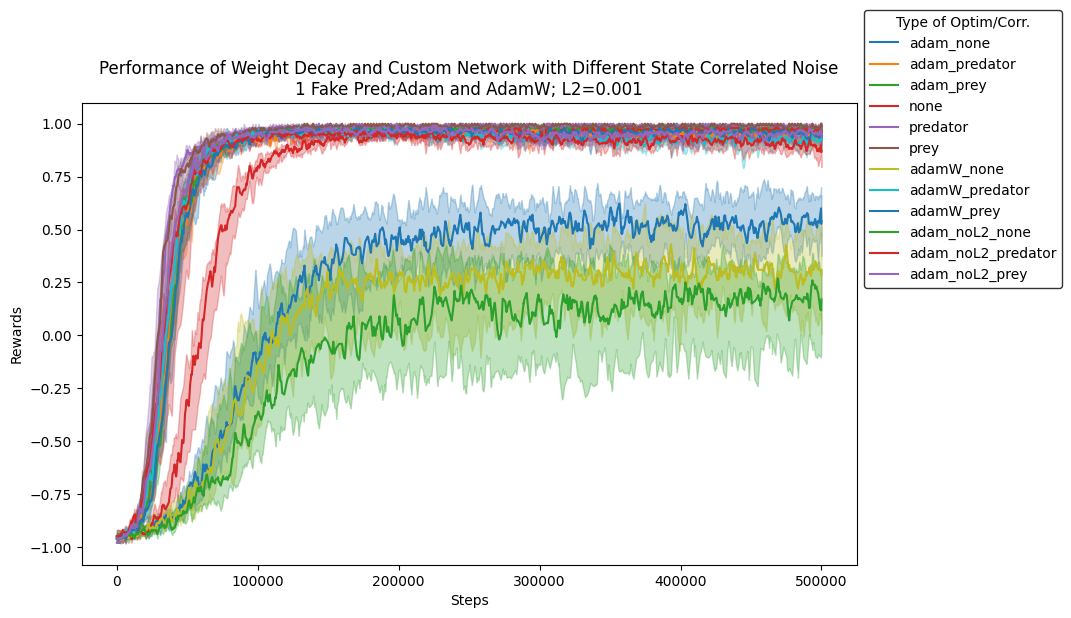

In [21]:
plt.figure(figsize=(10,6))
for m, t, b, n ,c in zip(n_means, n_tops, n_bottoms, ['adam_none', 'adam_predator', 'adam_prey'], colors):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
for m, t, b, n ,c in zip(means, tops, bottoms, ['none', 'predator', 'prey'], colors[3:]):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
for m, t, b, n ,c in zip(w_means, w_tops, w_bottoms, ['adamW_none', 'adamW_predator', 'adamW_prey'], colors[len(num_preds)*2:]):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
for m, t, b, n ,c in zip(no_means, no_tops, no_bottoms, ['adam_noL2_none', 'adam_noL2_predator', 'adam_noL2_prey'], colors[len(num_preds)*3:]):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
plt.title('Performance of Weight Decay and Custom Network with Different State Correlated Noise\n1 Fake Pred;Adam and AdamW; L2=0.001')
plt.xlabel('Steps')
plt.ylabel('Rewards')
leg = plt.legend(title='Type of Optim/Corr.', loc=(1.01, .6))
leg.get_frame().set_linewidth(1)
leg.get_frame().set_edgecolor('black')

# plt.savefig('adam_vs_adamW.pdf', format='pdf')
# plt.savefig('adam_vs_adamW.png', format='png')

plt.show()

In [22]:
maxls = {'none': np.argmax(means[0]), 'predator': np.argmax(means[1]), 'prey':np.argmax(means[2])}
maxs = {'none': np.max(means[0]), 'predator': np.max(means[1]), 'prey':np.max(means[2])}
w_maxls = {'w_none': np.argmax(w_means[0]), 'w_predator': np.argmax(w_means[1]), 'w_prey':np.argmax(w_means[2])}
w_maxs = {'w_none': np.max(w_means[0]), 'w_predator': np.max(w_means[1]), 'w_prey':np.max(w_means[2])}
no_maxls = {'noL2_none': np.argmax(no_means[0]), 'noL2_predator': np.argmax(no_means[1]), 'noL2_prey':np.argmax(no_means[2])}
no_maxs = {'noL2_none': np.max(no_means[0]), 'noL2_predator': np.max(no_means[1]), 'noL2_prey':np.max(no_means[2])}
time_to_95 = {'none': find_95_max(means[0]), 'predator': find_95_max(means[1]), 'prey': find_95_max(means[2])}
w_time_to_95 = {'w_none': find_95_max(w_means[0]), 'w_predator': find_95_max(w_means[1]), 'w_prey': find_95_max(w_means[2])}
no_time_to_95 = {'noL2_none': find_95_max(no_means[0]), 'noL2_predator': find_95_max(no_means[1]), 'noL2_prey': find_95_max(no_means[2])}
state_size_df = pd.DataFrame({'Time to Max Reward': {**maxls, **w_maxls, **no_maxls}, 
                              'Time to Learn (95% max)': {**time_to_95, **w_time_to_95, **no_time_to_95}, 
                              'Max Reward': {**maxs, **w_maxs, **no_maxs}})
state_size_df

,Time to Max Reward,Time to Learn (95% max),Max Reward
none,425302,208646,0.98666
predator,143360,82944,1.00000
prey,133120,88746,1.00000
w_none,393216,392877,0.43000
w_predator,129024,88815,0.98000
w_prey,171520,97852,0.98250
noL2_none,468992,468685,0.27000
noL2_predator,155648,86323,0.97000
noL2_prey,198656,93184,1.00000


In [4]:
means = []
tops = []
bottoms =[]
n_preds = ['adam_num_preds=1', 'adam_num_preds=2', 'adam_num_preds=3']
for num_preds in n_preds:
    files_path = '/home/mltrapp/meher/tune/WD_0.001_adam_real_preds_coll/num_preds=' + str(num_preds[-1])
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    means.append(m)
    tops.append(t)
    bottoms.append(b)
    
noL2_means = []
noL2_tops = []
noL2_bottoms =[]
noL2_preds = ['adam_noL2_num_preds=1', 'adam_noL2_num_preds=2', 'adam_noL2_num_preds=3']
for num_preds in n_preds:
    files_path = '/home/mltrapp/meher/tune/WD_0.000_adam_real_preds_coll/num_preds=' + str(num_preds[-1])
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    noL2_means.append(m)
    noL2_tops.append(t)
    noL2_bottoms.append(b)
    
adamW_means = []
adamW_tops = []
adamW_bottoms =[]
Wpreds = ['adamW_num_preds=1', 'adamW_num_preds=2', 'adamW_num_preds=3']
for num_preds in n_preds:
    files_path = '/home/mltrapp/meher/tune/WD_0.001_adamW_real_preds_coll/num_preds=' + str(num_preds[-1])
    m, std, t, b, all_repeat_rew = tb_to_stats(files_path, int(500E3))
    adamW_means.append(m)
    adamW_tops.append(t)
    adamW_bottoms.append(b)

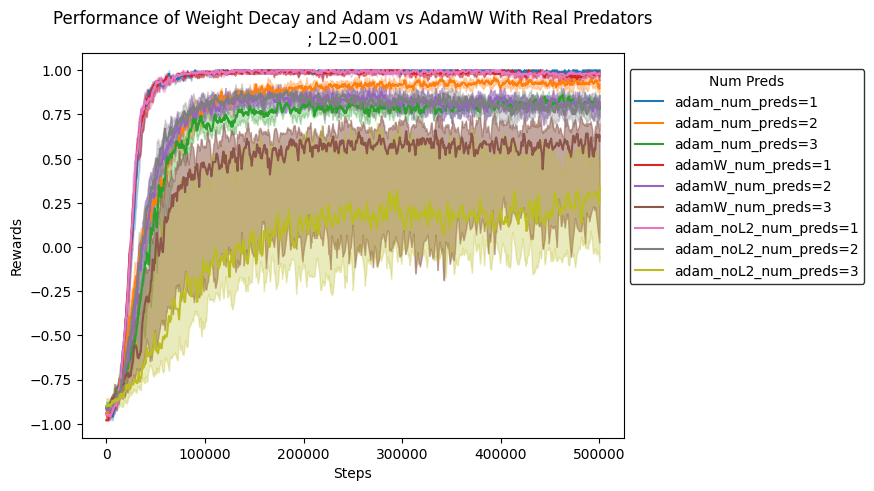

In [5]:
plt.figure(figsize=(7,5))
for m, t, b, n ,c in zip(means, tops, bottoms, n_preds, colors):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
for m, t, b, n ,c in zip(adamW_means, adamW_tops, adamW_bottoms, Wpreds, colors[len(n_preds):]):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
for m, t, b, n ,c in zip(noL2_means, noL2_tops, noL2_bottoms, noL2_preds, colors[len(n_preds)*2:]):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
plt.title('Performance of Weight Decay and Adam vs AdamW With Real Predators\n; L2=0.001')
plt.xlabel('Steps')
plt.ylabel('Rewards')
leg = plt.legend(title='Num Preds', loc=(1.01, .4))
leg.get_frame().set_linewidth(1)
leg.get_frame().set_edgecolor('black')

plt.savefig('WD_comparison_real_preds.pdf', format='pdf', bbox_inches='tight')
plt.savefig('WD_comparison_real_preds.png', format='png', bbox_inches='tight')

plt.show()

In [6]:
maxls = {'adam_n_preds=1': np.argmax(means[0]), 'adam_n_preds=2': np.argmax(means[1]), 'adam_n_preds=3':np.argmax(means[2])}
maxs = {'adam_n_preds=1': np.max(means[0]), 'adam_n_preds=2': np.max(means[1]), 'adam_n_preds=3':np.max(means[2])}
w_maxls = {'adam_w_n_preds=1': np.argmax(adamW_means[0]), 'adam_w_n_preds=2': np.argmax(adamW_means[1]), 'adam_w_n_preds=3':np.argmax(adamW_means[2])}
w_maxs = {'adam_w_n_preds=1': np.max(adamW_means[0]), 'adam_w_n_preds=2': np.max(adamW_means[1]), 'adam_w_n_preds=3':np.max(adamW_means[2])}
noL2_maxls = {'noL2_n_preds=1': np.argmax(noL2_means[0]), 'noL2_n_preds=2': np.argmax(noL2_means[1]), 'noL2_n_preds=3':np.argmax(noL2_means[2])}
noL2_maxs = {'noL2_n_preds=1': np.max(noL2_means[0]), 'noL2_n_preds=2': np.max(noL2_means[1]), 'noL2_n_preds=3':np.max(noL2_means[2])}
time_to_95 = {'adam_n_preds=1': find_95_max(means[0]), 'adam_n_preds=2': find_95_max(means[1]), 'adam_n_preds=3': find_95_max(means[2])}
w_time_to_95 = {'adam_w_n_preds=1': find_95_max(adamW_means[0]), 'adam_w_n_preds=2': find_95_max(adamW_means[1]), 'adam_w_n_preds=3': find_95_max(adamW_means[2])}
noL2_time_to_95 = {'noL2_n_preds=1': find_95_max(noL2_means[0]), 'noL2_n_preds=2': find_95_max(noL2_means[1]), 'noL2_n_preds=3': find_95_max(noL2_means[2])}
state_size_df = pd.DataFrame({'Time to Max Reward': {**maxls, **w_maxls, **noL2_maxls}, 
                              'Time to Learn (95% max)': {**time_to_95, **w_time_to_95, **noL2_time_to_95}, 
                              'Max Reward': {**maxs, **w_maxs, **noL2_maxs}})
state_size_df

,Time to Max Reward,Time to Learn (95% max),Max Reward
adam_n_preds=1,90112,68950,1.000000
adam_n_preds=2,393216,216542,0.960000
adam_n_preds=3,462848,451891,0.860000
adam_w_n_preds=1,118784,64854,1.000000
adam_w_n_preds=2,266240,219019,0.880000
adam_w_n_preds=3,333824,333195,0.660000
noL2_n_preds=1,110592,62806,1.000000
noL2_n_preds=2,183091,138667,0.881997
noL2_n_preds=3,499999,499950,0.339653


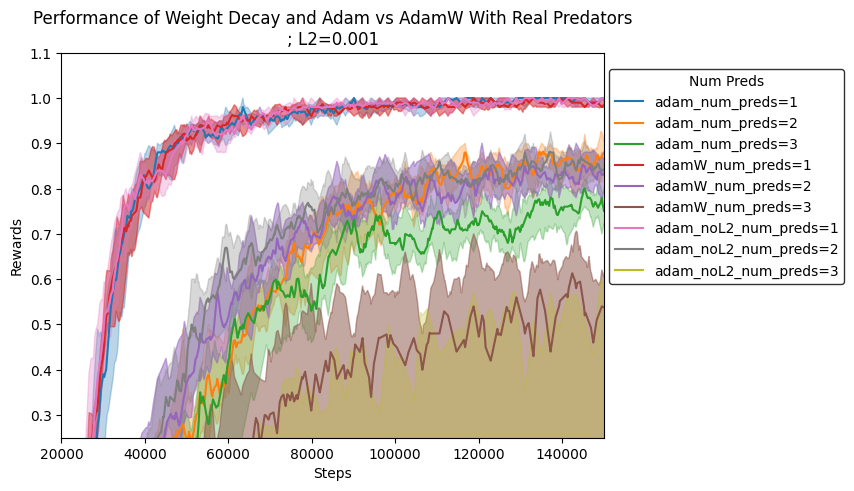

In [7]:
plt.figure(figsize=(7,5))
for m, t, b, n ,c in zip(means, tops, bottoms, n_preds, colors):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
for m, t, b, n ,c in zip(adamW_means, adamW_tops, adamW_bottoms, Wpreds, colors[len(n_preds):]):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
for m, t, b, n ,c in zip(noL2_means, noL2_tops, noL2_bottoms, noL2_preds, colors[len(n_preds)*2:]):
    plt.plot(m, label=n, color=c)
    plt.fill_between(np.arange(len(m)), m+t, m-b, alpha=0.3, color=c)
plt.title('Performance of Weight Decay and Adam vs AdamW With Real Predators\n; L2=0.001')
plt.xlabel('Steps')
plt.ylabel('Rewards')
plt.xlim(20000, 150000)
plt.ylim(0.25, 1.10)
leg = plt.legend(title='Num Preds', loc=(1.01, .4))
leg.get_frame().set_linewidth(1)
leg.get_frame().set_edgecolor('black')

plt.savefig('Zoomed_Preds_comparison_WD.pdf', format='pdf', bbox_inches='tight')
plt.savefig('Zoomed_Preds_comparison_WD.png', format='png', bbox_inches='tight')

plt.show()